In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import pickle 
import tensorflow as tf 
import time
import os 
from IPython.display import display 
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline
%config  InlineBackend.figure_formats = {'png', 'retina'}
sns.set_style("white")

# Face To Pictogram



<img src="">



### Load tfrecord

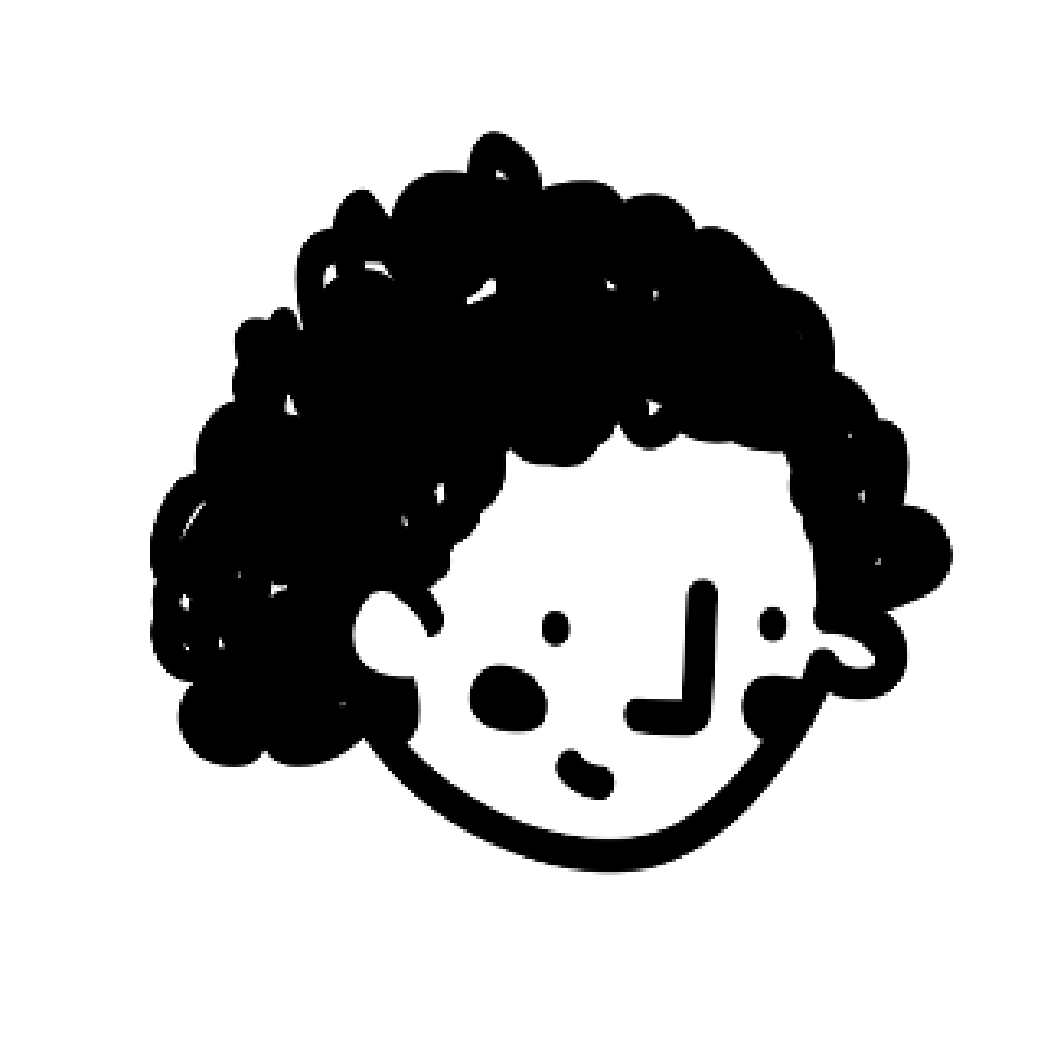

In [2]:
pic_path = "../Dataset/tfrecord/pictogram.tfrecord"
real_path = "../Dataset/tfrecord/real_image.tfrecord"

pic_images = []
pic_sexes = []
real_images = []
real_sexes = []

real_record_iterator = tf.python_io.tf_record_iterator(path=real_path)
pic_record_iterator = tf.python_io.tf_record_iterator(path=pic_path)


for str_real_record, str_pic_record in zip(real_record_iterator, pic_record_iterator):
    example_real = tf.train.Example()
    example_real.ParseFromString(str_real_record)
    
    height = int(example_real.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example_real.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example_real.features.feature['gray_img_bytes']
                                  .bytes_list
                                  .value[0])
    
    sex = float(example_real.features.feature['sex']
                                .float_list
                                .value[0])
    
    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    # 마지막 axis에 7개의 0이 추가 된다. 
    reconstructed_img = np.amax(reconstructed_img, axis=-1)

    real_images.append(reconstructed_img)
    real_sexes.append(sex)
    
    example_pic = tf.train.Example()
    example_pic.ParseFromString(str_pic_record)
    
    height = int(example_pic.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example_pic.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example_pic.features.feature['gray_img_bytes']
                                  .bytes_list
                                  .value[0])
    
    sex = float(example_pic.features.feature['sex']
                                .float_list
                                .value[0])
    
    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    # 마지막 axis에 7개의 0이 추가 된다. 
    reconstructed_img = np.amax(reconstructed_img, axis=-1)

    pic_images.append(reconstructed_img)
    pic_sexes.append(sex)
    

       
plt.figure(figsize=(9,9))
plt.axis("off")
plt.imshow(reconstructed_img, cmap="gray")
plt.show()

In [3]:
pic_images = np.array(pic_images).reshape(-1, height, width, 1)
real_images = np.array(real_images).reshape(-1, height, width, 1)

In [4]:
pic_images =  pic_images.astype(np.float32)
real_images = real_images.astype(np.float32)
pic_images.shape, real_images.shape

((34, 300, 300, 1), (34, 300, 300, 1))

In [5]:
import math
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops

In [6]:
# powerful normalization method for style trasfering problem, which normaaly has few dataset 
def instance_norm(x, name="instance_norm"):
    """
    instance normalization 
    paper's link = https://arxiv.org/pdf/1607.08022.pdf
    'it increases style transfering models' perfomance' 
    """
    with tf.variable_scope(name):
        depth = x.get_shape()[3]
        # two learnable parameters : scale, offset 
        scale = tf.get_variable("scale", [depth], initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32))
        offset = tf.get_variable("offset", [depth], initializer=tf.constant_initializer(0.0))
        mean, variance = tf.nn.moments(x, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (x-mean)*inv
        return scale*normalized + offset
# conv2d 
def conv2d(input_, output_dim=8, kernel_size=5, stride=1, stddev=0.02, padding='SAME', name="conv2d"):
    """ generating conv2d layer
    
    args :
    input_ : input 
    output_dim : output_dim
    kernel_size : 4
    stride : 2 
    stddev : tf.truncated_normal_initializer(stddev=stddev)
    padding : SAME
    name : conv2d
    
    return :
    slim.conv2d(input_, output_dim, kernel_size, stride, padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

    """
    with tf.variable_scope(name):
        return slim.conv2d(input_, output_dim, kernel_size=kernel_size, stride=stride, 
                           padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

#leaky relu    
def lrelu(x, leaky=0.2, name="leaky_relu"):
    
    return tf.maximum(x, leaky * x)


#### Discriminator & Generator 

##### Discriminator 


- Q1. why discriminator's output is 32x32x1 
> I thought discriminator has a role of discriminating fake or real with 0, 1 each.
> is it technic ? 

>> **This Answer was writen on the paper**
>> - by implementing, reserchers dose Johnson 's Residual architecture which is known as very productive on style transfering problem for generator, and use **PatchGAN**'s discriminator 


###### PatchGAN research 

 > blah blah
 
##### Discriminator 

- In the paper, Generator is **Johnson's model** which have shown imporessive results for neural style transfer and superresolution
> but my target image is quite simple form, So I create the generator with DenseNet architecture for reducing operation and the number of parameters. 

In [7]:
def discriminator(image, output_dim=8, reuse=False, name="discriminator"):
    with tf.variable_scope(name):
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else :
            assert tf.get_variable_scope().reuse is False

        # h0 is (150 x 150 x self.df_dim)
        h0 = lrelu(conv2d(image, output_dim, stride=2, name='dis_h0_conv'))
        # h1 is (75 x 75 x self.df_dim*2)
        h1 = lrelu(instance_norm(conv2d(h0, output_dim*2, stride=2, name='d_h1_conv'), 'd_in1'))
        # h2 is (36 x 36 x self.df_dim*4)
        h2 = lrelu(instance_norm(conv2d(h1, output_dim*4, stride=2, name='d_h2_conv'), 'd_in2'))
        # h3 is (36 x 36 x self.df_dim*8)
        h3 = lrelu(instance_norm(conv2d(h2, output_dim*8, name='d_h3_conv'), 'd_in3'))
        # h4 is (36 x 36 x 1)
        h4 = conv2d(h3, 1, name='d_h3_pred')

        return h4

    
def generator_dense(image, reuse=False, name="generator"):
    with tf.variable_scope(name):
        # image = 300x300x1
        
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False
            
        def dense_block(x, growth_rate=8, num_layers_in_block=6, name="dense"):
            
            for i in range(num_layers_in_block):    
                y1 = instance_norm(conv2d(x, growth_rate*2, 
                                          kernel_size=1,
                                          padding='SAME', 
                                          name=name+'_bot{}'.format(i)), name+'_in1{}'.format(i))
                y2 = instance_norm(conv2d(y1, growth_rate, 
                                          kernel_size=3, 
                                          padding='SAME', 
                                          name=name+'_tle{}'.format(i)), name+'_in2{}'.format(i))

                x = tf.concat([y2, x], -1)
                
            return x
                
                
        dense_layer_1 = dense_block(image, name="dense_1")
        
        # Maintaing Feature map size , Reduce # of channels  
        transition_layer = instance_norm(conv2d(dense_layer_1, 1, 
                                          kernel_size=3, 
                                          padding='SAME', 
                                          name=name+'_transition1'), name+'_in1')
        
        dense_layer_2 = dense_block(transition_layer, name="dense_2")
        
        
        output_layer = instance_norm(conv2d(dense_layer_2, 1, 
                                          kernel_size=3, stride=1, 
                                          padding='SAME', 
                                          name=name+'_out'), name+'_in_out')
        
        
        return output_layer
    
    
# Loss functions     

def abs_criterion(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))


def mse_criterion(in_, target):
    return tf.reduce_mean((in_ - target)**2)


def sce_criterion(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))


In [8]:
# Model building 
L1_lambda = 10 # from paper
height = 300 
width = 300 

# True image 
# face_pic_data = tf.placeholder(tf.float32, 
#                               [None, height, width, 2])

# face = face_pic_data[:,:,:, 0]
# pic = face_pic_data[:,:,:, 1]

face = tf.placeholder(tf.float32, [None, height, width, 1])
pic = tf.placeholder(tf.float32, [None, height, width, 1])

# Fake image 
# Face -> pic -> Face'
fake_pic = generator_dense(face, name="generator_Face2Pic")
fake_face_ = generator_dense(fake_pic, name="generator_Pic2Face")
# Pic -> Face -> Pic'
fake_face = generator_dense(pic, reuse=True, name="generator_Pic2Face")
fake_pic_ = generator_dense(fake_face, reuse=True, name="generator_Face2Pic")
#############################################
dis_pic_fake = discriminator(fake_pic, reuse=False, name='discriminator_Pic')
dis_face_fake = discriminator(fake_face, reuse=False, name='discriminator_Face')

gen_loss_Face2Pic = sce_criterion(dis_pic_fake, tf.ones_like(dis_pic_fake)) + L1_lambda * abs_criterion(face, fake_face_) + L1_lambda * abs_criterion(pic, fake_pic_) 
gen_loss_Pic2Face = sce_criterion(dis_face_fake, tf.ones_like(dis_face_fake)) + L1_lambda * abs_criterion(face, fake_face_) + L1_lambda * abs_criterion(pic, fake_pic_) 
gen_loss = sce_criterion(dis_pic_fake, tf.ones_like(dis_pic_fake)) + sce_criterion(dis_face_fake, tf.ones_like(dis_face_fake))+ L1_lambda * abs_criterion(face, fake_face_) + L1_lambda * abs_criterion(pic, fake_pic_)
######################################################
fake_face_sample = tf.placeholder(tf.float32, 
                                 [None, height, width, 1], name='fake_face') 
fake_pic_sample = tf.placeholder(tf.float32, 
                                 [None, height, width, 1], name='fake_pic') 

dis_pic_real = discriminator(pic, reuse=True, name='discriminator_Pic')
dis_face_real = discriminator(face, reuse=True, name='discriminator_Face')

dis_fake_face_sample = discriminator(fake_face_sample, reuse=True, name="discriminator_Face") 
dis_fake_pic_sample = discriminator(fake_pic_sample, reuse=True, name="discriminator_Pic")

dis_pic_loss_real = sce_criterion(dis_pic_real, tf.ones_like(dis_pic_real))
dis_pic_loss_fake = sce_criterion(dis_fake_pic_sample, tf.zeros_like(dis_fake_pic_sample))
dis_pic_loss = (dis_pic_loss_fake + dis_pic_loss_real) / 2

dis_face_loss_real = sce_criterion(dis_face_real, tf.ones_like(dis_face_real))
dis_face_loss_fake = sce_criterion(dis_fake_face_sample, tf.zeros_like(dis_fake_face_sample))
dis_face_loss = (dis_face_loss_fake + dis_face_loss_real) / 2

##### 
dis_loss = dis_pic_loss + dis_face_loss

## for summary 

####### Generator
gen_loss_Face2Pic_summ = tf.summary.scalar("gen_loss_Face2Pic", gen_loss_Face2Pic)
gen_loss_Pic2Face_summ = tf.summary.scalar("gen_loss_Pic2Face", gen_loss_Pic2Face)
gen_loss_summ = tf.summary.scalar("gen_loss", gen_loss)

gen_summ = tf.summary.merge([gen_loss_Face2Pic_summ, gen_loss_Pic2Face_summ, gen_loss_summ])

####### Discriminator
dis_pic_loss_real_summ = tf.summary.scalar("dis_pic_loss_real", dis_pic_loss_real)
dis_pic_loss_fake_summ = tf.summary.scalar("dis_pic_loss_fake", dis_pic_loss_fake)
dis_pic_loss_summ = tf.summary.scalar("dis_pic_loss", dis_pic_loss)
dis_face_loss_real_summ = tf.summary.scalar("dis_face_loss_real", dis_face_loss_real)
dis_face_loss_fake_summ = tf.summary.scalar("dis_face_loss_fake", dis_face_loss_fake)
dis_face_loss_summ = tf.summary.scalar("dis_face_loss", dis_face_loss)
dis_loss_summ = tf.summary.scalar("dis_loss", dis_loss)

dis_summ =tf.summary.merge([dis_pic_loss_real_summ, dis_pic_loss_fake_summ,dis_pic_loss_summ, 
                          dis_face_loss_real_summ, dis_face_loss_fake_summ, dis_face_loss_summ,
                         dis_loss_summ])

###### Testing 

test_face = tf.placeholder(tf.float32, 
                          [None, height, width, 1], name='test_Face')
test_pic = tf.placeholder(tf.float32, 
                          [None, height, width, 1], name='test_Pic')

test_pic = generator_dense(test_face, reuse=True, name="generator_Face2Pic")
test_face = generator_dense(test_pic, reuse=True, name="generator_Pic2Face")



#### Train

In [9]:
lr = 0.001
total_variables = tf.trainable_variables()
dis_var = [var for var in total_variables if 'discriminator' in var.name]
gen_var = [var for var in total_variables if 'generator' in var.name]

epochs = 300

## no batch-wise training

## optimizers 
dis_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(dis_loss, var_list=dis_var)
gen_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(gen_loss, var_list=gen_var)

with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    writer = tf.summary.FileWriter("./logs", sess.graph)
    start_time = time.time()
    counter = 1
    
    for epoch in range(epochs):
        ## update Generator and record Fake images 
        fake_Face, fake_Pic, _, summary_str = sess.run(
                                    [fake_face, fake_pic, gen_op, gen_summ], 
                                    feed_dic={face:real_images, pic:pic_images})
        writer.add_summary(summary_str, counter)
        
        ## update Discriminator 
        
        _, summary_str = sess.run(
                                [dis_op, dis_summ],
                            feed_dict={
                                face:real_images,
                                pic:pic_images,
                                fake_face_sample:fake_Face,
                                fake_pic_sample:fake_Pic})
        writer.add_summary(summary_str, counter)
        
        counter += 1 
        print("Epoch : {}/{}, time : {}, ".format(epoch, epochs, time.time() - start_time))
        
        if counter % 100 == 0 or counter == 1:
            test_Face2Pic = sess.run(test_pic, feed_dict={test_face:real_images})
            for img in test_Face2Pic:
                plt.figure(figsize=(9,9))
                plt.imshow(img.reshape(300, 300))
                plt.show()
    

#### Save

In [13]:
model_name = "Face_to_Pic.model"
model_dir = "./model"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
saver = tf.train.Saver()

saver.save(sess, os.path.join(model_dir, model_name))



NameError: name 'os' is not defined